# The Kullback-Leibler Divergence

The KL divergence is used as a measure of how close an approximation to a probability distribution is to the true probability distribution it approximates.  In this notebook, we try to gain some intuition about the magnitude of the KL divergence by computing its value between two Gaussian PDFs as a function of the "precision" and "tension" between them.

### Requirements

You'll need the `qp` package and its dependencies (notably `scipy` and matplotlib).

## Background

The Kullback-Leibler divergence between probability distributions $P$ and $Q$ is:

$D(P||Q) = \int_{-\infty}^{\infty} \log \left( \frac{P(x)}{Q(x)} \right) P(x) dx$

The Wikipedia page for the KL divergence gives the following useful interpretation of the KLD:

> KL divergence is a measure of the difference between two probability distributions $P$ and $Q$. It is not symmetric in $P$ and $Q$. In applications, $P$ typically represents ... a precisely calculated theoretical distribution, while $Q$ typically represents ... [an] approximation of $P$.
>
> Specifically, the Kullback–Leibler divergence from $Q$ to $P$, denoted $D_{KL}(P‖Q)$, is a measure of the information gained when one revises one's beliefs from ... $Q$ to ... $P$. In other words, it is the amount of information lost when $Q$ is used to approximate $P$.


## 1D Gaussian Illustration

"Information" is not a terribly familiar quantity to most of us, so let's compute the KLD between two Gaussians:

* The "True" 1D Gaussian PDF, $P(x)$, of unit width and central value 0

* An "approximating" 1D Gaussian PDF, $Q$, of width $\sigma$ and centroid $x$

How does the KLD between these PDFs vary with offset $x$ and width $\sigma$?

In [7]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import qp

import numpy as np
import scipy.stats as sps

In [8]:
P = qp.Ensemble(qp.norm_gen, data=dict(loc=[[0.0]], scale=[[1.0]]))

In [9]:
x, sigma = 2.0, 1.0
Q = qp.Ensemble(qp.norm_gen, data=dict(loc=[[x]], scale=[[sigma]]))

In [10]:
infinity = 100.0
D = qp.metrics.calculate_kld(P, Q, limits=(-infinity,infinity))
print (D)

1.9999999998879543


i.e. Two equal-width Gaussians overlapping at their 1-sigma points have a KLD of 2 nats. 

> The unit of information here is a "nat" rather than a "bit" because `qp` uses a natural logarithm in its KLD calculation. 1 nat = $1/\log{2} \approx 1.44$  bits. 

What if the two Gaussians are perfectly aligned, but the approximation is broader than the truth?

In [11]:
x, sigma = 0.0, 4.37
Q = qp.Ensemble(qp.norm_gen, data=dict(loc=[[x]], scale=[[sigma]]))
D = qp.metrics.calculate_kld(P, Q, limits=(-infinity,infinity))
print (D)

1.0009452690554488


i.e. Two concentric 1D Gaussian PDFs differing in width by a factor of 4.37 have a KLD of 1 nat.

## Analytic Formulae

### Precision

The KL divergence, in nats, between an approximating, lower precision, correctly aligned Gaussian of variance $\sigma^{2}$ and a true Gaussian of variance $\sigma_{0}^{2}$ is related to the ratio between the two distribution widths:

\begin{align*}
D &= \int_{-\infty}^{\infty}P(x)\log\left[\frac{P(x)}{Q(x)}\right]dx\\
&= \int_{-\infty}^{\infty}P(x)\log[P(x)]dx-\int_{-\infty}^{\infty}P(x)\log[Q(x)]dx\\
&= \int_{-\infty}^{\infty}\frac{1}{\sqrt{2\pi}\sigma_{0}}\exp[-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]\log[\frac{1}{\sqrt{2\pi}\sigma_{0}}\exp[-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]]dx-\int_{-\infty}^{\infty}\frac{1}{\sqrt{2\pi}\sigma_{0}}\exp[-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]\log[\frac{1}{\sqrt{2\pi}\sigma}\exp[-\frac{(x-x_{0})^{2}}{2\sigma^{2}}]]dx\\
&= \frac{1}{\sqrt{2\pi}\sigma_{0}}\left(\int_{-\infty}^{\infty}\exp[-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]\left(-\log[\sqrt{2\pi}\sigma_{0}]-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]\right)dx-\int_{-\infty}^{\infty}\exp[-\frac{(x-x_{0})^{2}}{2\sigma_{0}^{2}}]\left(-\log[\sqrt{2\pi}\sigma]-\frac{(x-x_{0})^{2}}{2\sigma^{2}}\right)]dx\right)
\end{align*}

We substitute $u=\frac{(x-x_{0})^{2}}{2\sigma_{0}}$:

\begin{align*}
D &= \frac{1}{\sqrt{2\pi}\sigma_{0}}\left(\int\exp[-u]\left(-\log[\sqrt{2\pi}\sigma_{0}]-u]\right)\frac{du}{\frac{\sqrt{2u}}{\sigma_{0}}}-\int\exp[-u]\left(-\log[\sqrt{2\pi}\sigma]-\frac{\sigma_{0}^{2}}{\sigma^{2}}u\right)]\frac{du}{\frac{\sqrt{2u}}{\sigma_{0}}}\right)\\
&= \frac{1}{2\sqrt{\pi}}\left(\int\left(-\log[\sqrt{2\pi}\sigma_{0}]u^{-\frac{1}{2}}\exp[-u]-u^{\frac{1}{2}}\exp[-u]\right)du-\int\left(-\log[\sqrt{2\pi}\sigma]u^{-\frac{1}{2}}\exp[-u]-\frac{\sigma_{0}^{2}}{\sigma^{2}}u^{\frac{1}{2}}\exp[-u]\right)du\right)\\
&= -\frac{1}{2\sqrt{\pi}}\left(\left(\log[\sqrt{2\pi}\sigma_{0}]\left[\sqrt{\pi}erf[u^{\frac{1}{2}}]\right]+\left[\frac{\sqrt{\pi}}{2}erf[u^{\frac{1}{2}}]-u^{-\frac{1}{2}}\exp[-u]\right]\right)-\left(\log[\sqrt{2\pi}\sigma]\left[\sqrt{\pi}erf[u^{\frac{1}{2}}]\right]+\frac{\sigma_{0}^{2}}{\sigma^{2}}\left[\frac{\sqrt{\pi}}{2}erf[u^{\frac{1}{2}}]-u^{-\frac{1}{2}}\exp[-u]\right]\right)\right)
\end{align*}

We transform back and evaluate this at the limits:

\begin{align*}
D &= -\frac{1}{2\sqrt{\pi}}\left(\left(\log[\sqrt{2\pi}\sigma_{0}]\left[2\sqrt{\pi}]\right]+\left[\sqrt{\pi}]\right]\right)-\left(\log[\sqrt{2\pi}\sigma]\left[2\sqrt{\pi}]\right]+\frac{\sigma_{0}^{2}}{\sigma^{2}}\left[\sqrt{\pi}]\right]\right)\right)\\
&= -\frac{1}{2}\left(\log\left[\frac{\sigma_{0}}{\sigma}\right]+1-\frac{\sigma_{0}^{2}}{\sigma^{2}}\right)
\end{align*}

where $\sigma_0$ is the width of the true distribution.

We can perhaps take the KL divergence to provide a generalized quantification of increase of precision, as in: the increase in precision $r^{-1}$ going from approximation to truth, which in the 1D Gaussian case is just 
### $r^{-1}\equiv\frac{\sigma_{0}}{\sigma}\approx\exp[-2D]$.

### Tension

The KL divergence, in nats, between an approximating Gaussian and a true Gaussian is _approximately_ equal to the square of the tension between the two distributions.  By a similar derivation to the above, we obtain

## $D = \log[r]-\frac{1}{2}(1-r^{-2})+\frac{1}{2}(1+r^{-2})t^{2} \approx t^2$ 

where tension $t$ is defined as

## $t = \frac{\Delta x}{\sqrt{\left(\sigma_0^2 + \sigma^2\right)}}$

and has, in some sense, "units" of "sigma". The KLD is the information lost when using the approximation: the information loss rises in proprtion to the tension squared. The above formula is most accurate in the limit where the two distributions have the same width.

Still, we can see that the KL divergence might provide a route to a generalized quantification of tension.  The square root of the KLD between a PDF and its approximation, in nats, gives an approximate sense of the tension between the two distributions, in "units" of "sigma":

## $t \approx \sqrt{D}$

## Approximation Precision

Suppose our approximating PDF is broader than the true PDF, but the centroids are aligned. If we were to use our approximation, we'd be over-estimating the uncertainty in the inference. The approximating PDF represents a lower _precision_ measurement. Let's look at how the KLD quantifies this change in precision, as a function of the change in PDF width. 

In [12]:
widths = np.logspace(-2.0,2.0,13)
D = np.empty_like(widths)
E = np.empty_like(widths)

x = 0.0
infinity = 1000.0

for k,sigma in enumerate(widths):
    Q = qp.Ensemble(qp.norm_gen, data=dict(loc=[[x]], scale=[[sigma]]))
    D[k] = qp.metrics.calculate_kld(P, Q, limits=(-infinity,infinity))
    E[k] = qp.metrics.calculate_rmse(P, Q, limits=(-infinity,infinity))

for w,dd, in zip(widths, D):
    print(w, dd)

0.01 32.73967201078749
0.021544346900318832 30.696053656827
0.046415888336127774 26.516629840956828
0.1 18.593259424578648
0.21544346900318834 7.529710324658465
0.46415888336127775 1.0528955853569166
1.0 0.0
2.154434690031882 0.3752500988329423
4.6415888336127775 1.0582646728307612
10.0 1.8075850929940458
21.54434690031882 2.57119067467041
46.41588833612777 3.337873901098424
100.0 4.105220185988092


/Users/echarles/miniconda3/envs/txpipe-py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


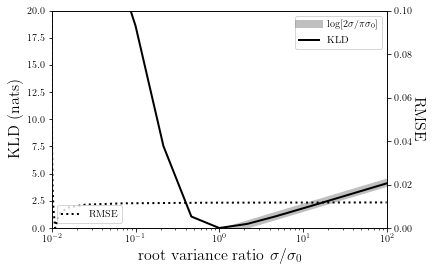

In [13]:
x = widths
y = np.log(widths*(2.0/np.pi))

# plt.plot(widths, D, color='black', linestyle='-', lw=2.0, alpha=1.0, label='Offset=0.0')
# plt.xscale('log')
# plt.ylim(0.0,32.0)
# plt.xlabel('Width of approximating Gaussian $\sigma$')
# plt.ylabel('KL divergence (nats)')
# l = plt.legend(loc='upper right')
# plt.show()

# plt.plot(widths, E, color='black', linestyle='-', lw=2.0, alpha=1.0, label='Offset=0.0')
# plt.xscale('log')
# plt.xlabel('Width of approximating Gaussian $\sigma$')
# plt.ylabel('RMSE')
# l = plt.legend(loc='upper right')
# plt.show()

fig, ax = plt.subplots()
ax.plot(x, y, color='gray', linestyle='-', lw=8.0, alpha=0.5, label=r'$\log[2\sigma/\pi\sigma_{0}]$')
ax.set_xscale('log')
ax.set_xlabel(r'root variance ratio $\sigma/\sigma_{0}$')
ax.set_xlim(1e-2, np.max(widths))
ax.set_ylim(0, 20)
ax.plot(widths, D, color='k', linestyle='-', lw=2.0, alpha=1.0, label='KLD')
ax.set_ylabel('KLD (nats)')
l = ax.legend(loc='upper right')
axr = ax.twinx()
axr.set_ylim(0, 0.1)
axr.plot(widths, E, color='k', linestyle=':', lw=2.0, alpha=1.0, label='RMSE')
axr.set_ylabel('RMSE', rotation=270, labelpad=15)
l = axr.legend(loc= 'lower left')
fig.show()
fig.savefig('precision.pdf', dpi=250)

It looks as though using an increasingly broad approximation distribution leads to logarithmically increasing information loss. 

When the approximating distribution gets _narrower_ than the truth, information is lost at a faster rate, which is interesting.

## Tension between PDFs

Two measurements that disagree with each other will lead to parameter PDFs that have different cenrtroids. Let's tabulate the KLD for a range of distribution offsets.

In [14]:
separations = np.linspace(0.0,15.0,16)
D = np.empty_like(separations)
E = np.empty_like(separations)

sigma = 1.0
infinity = 100.0

for k,x0 in enumerate(separations):
    Q = qp.Ensemble(qp.norm_gen, data=dict(loc=[[x0]], scale=[[sigma]]))
    D[k] = qp.metrics.calculate_kld(P, Q, limits=(-infinity,infinity))
    E[k] = qp.metrics.calculate_rmse(P, Q, limits=(-infinity,infinity))

for ss, DD in zip(separations, D):
    print(ss, DD)

0.0 0.0
1.0 0.4999999999999129
2.0 1.9999999998879543
3.0 4.499999944790901
4.0 7.999989426527567
5.0 12.499196751356507
6.0 17.975007794448604
7.0 24.1645156552465
8.0 29.88406466674725
9.0 33.33649094370043
10.0 34.44663752887975
11.0 34.613550117533755
12.0 34.624419312399404
13.0 34.62471169371037
14.0 34.62471484260234
15.0 34.62471485589082


/Users/echarles/miniconda3/envs/txpipe-py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


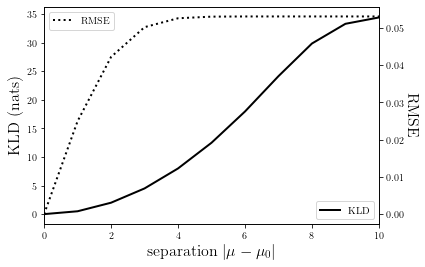

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel(r'separation $|\mu-\mu_{0}|$')
ax.set_xlim(0, 10)
ax.set_xlim(0, np.max(D))
ax.plot(separations, D, color='k', linestyle='-', lw=2.0, alpha=1.0, label='KLD')
ax.set_ylabel('KLD (nats)')
l = ax.legend(loc='lower right')
axr = ax.twinx()
axr.plot(separations, E, color='k', linestyle=':', lw=2.0, alpha=1.0, label='RMSE')
axr.set_ylabel('RMSE', rotation=270, labelpad=15)
axr.set_xlim(0, 10)
l = axr.legend(loc='upper left')
fig.show()

> For separations greater than about 7 sigma, numerical precision starts to matter: the overlap integral out here is smaller than machine precision. `qp` uses a `safelog` function that replaces values smaller than the system threshold value with that threshold; the log of that threshold is:

In [16]:
import sys
print (np.log(sys.float_info.epsilon))

-36.04365338911715


> Probably the precision analysis of the previous section suffered from the same type of numerical error, at very low approximation distribution widths.

Presumably what matters is the "tension" between the two distributions: the separation in units of the combined width, $\sqrt{\sigma_0^2 + \sigma^2}$. This quantity comes up often in discussions of dataset combination, where the difference in centroids of two posterior PDFs needs to be expressed in terms of their widths: the quadratic sum makes sense in this context, since it would appear in the product of the two likelihoods were they to be combined.

For a few different widths, let's plot KLD vs tension.

In [17]:
infinity = 100.0
widths = np.array([1.0,1.5,2.0,2.5,3.0,3.5,4.0]) 
separations = np.linspace(0.0,7.0,15)

D = np.zeros([7,len(separations)])
E = np.zeros([7,len(separations)])
tensions = np.empty_like(D)

for j,sigma in enumerate(widths):
    
    for k,x0 in enumerate(separations):
        Q = qp.Ensemble(qp.norm_gen, data=dict(loc=[[x0]], scale=[[sigma]]))
        D[j,k] = qp.metrics.calculate_kld(P, Q, limits=(-infinity,infinity))
        E[j,k] = qp.metrics.calculate_rmse(P, Q, limits=(-infinity,infinity))
        tensions[j,k] = x0 / np.sqrt(sigma*sigma + 1.0)
        

/Users/echarles/miniconda3/envs/txpipe-py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


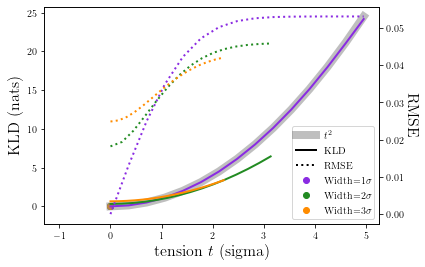

In [18]:
x = tensions[0,:]
y = x**2

fig, ax = plt.subplots()
ax.plot(x, y, color='gray', linestyle='-', lw=8.0, alpha=0.5, label='$t^2$')
ax.set_xlabel('tension $t$ (sigma)')
ax.plot([-1], [-1], color='black', linestyle='-', lw=2.0, alpha=1.0, label='KLD')
ax.plot([-1], [-1], color='black', linestyle=':', lw=2.0, alpha=1.0, label='RMSE')
colors = {'blueviolet':1.0, 'forestgreen':2.0, 'darkorange':3.0}
for item in colors.keys():
    ax.scatter([0], [0], color=item, label='Width='+str(colors[item])[0]+r'$\sigma$')

ax.plot(tensions[0,:], D[0,:], color='blueviolet', linestyle='-', lw=2.0, alpha=1.0)#, label='Width=1.0')
# ax.plot(tensions[1,:], D[1,:], color='violet', linestyle='-', lw=2.0, alpha=1.0, label='Width=1,5')
ax.plot(tensions[2,:], D[2,:], color='forestgreen', linestyle='-', lw=2.0, alpha=1.0)#, label='Width=2.0')
# ax.plot(tensions[3,:], D[3,:], color='green', linestyle='-', lw=2.0, alpha=1.0, label='Width=2.5')
ax.plot(tensions[4,:], D[4,:], color='darkorange', linestyle='-', lw=2.0, alpha=1.0)#, label='Width=3.0')
# ax.plot(tensions[5,:], D[5,:], color='orange', linestyle='-', lw=2.0, alpha=1.0, label='Width=3.5')
# ax.plot(tensions[6,:], D[6,:], color='forestgreen', linestyle='-', lw=2.0, alpha=1.0, label='Width=4.0')
ax.set_ylabel('KLD (nats)')
l = ax.legend(loc='lower right')

axr = ax.twinx()
axr.plot(tensions[0,:], E[0,:], color='blueviolet', linestyle=':', lw=2.0, alpha=1.0)#, label='Width=1.0')
# axr.plot(tensions[1,:], E[1,:], color='violet', linestyle=':', lw=2.0, alpha=1.0, label='Width=1,5')
axr.plot(tensions[2,:], E[2,:], color='forestgreen', linestyle=':', lw=2.0, alpha=1.0)#, label='Width=2.0')
# axr.plot(tensions[3,:], E[3,:], color='green', linestyle=':', lw=2.0, alpha=1.0, label='Width=2.5')
axr.plot(tensions[4,:], E[4,:], color='darkorange', linestyle=':', lw=2.0, alpha=1.0)#, label='Width=3.0')
# axr.plot(tensions[5,:], E[5,:], color='orange', linestyle=':', lw=2.0, alpha=1.0, label='Width=3.5')
# axr.plot(tensions[6,:], E[6,:], color='forestgreen', linestyle=':', lw=2.0, alpha=1.0, label='Width=4.0')
axr.set_ylabel('RMSE', rotation=270, labelpad=15)

fig.show()
fig.savefig('tension.pdf', dpi=250)


## Conclusions

To summarize, the KL divergence $D$ is an appropriate metric of an approximation to a probability distribution, expressing the loss of information of the approximation from the true distribution.  The simple numerical experiments in this notebook suggest the following approximate extrapolations and hypotheses.  

Using a Gaussian example enables exploration of two quantities characterizing the approximate distribution: the "precision" $r^{-1}$ is a measure of the width of the approximating distribution relative to the truth, and the "tension" $t$ is a measure of the difference in centroids weighted by the root-mean-square width of the two distributions.  We have found that the KLD can be interpreted in terms of these quantities; the KLD is proportional to the log of the precision and the square of the tension.